In [1]:
from transformers.trainer import Trainer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pytorch_lightning import Trainer, Callback,LightningModule
import missingno as msno
from torch import nn
import torch
from sklearn.metrics import accuracy_score
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader,RandomSampler,SequentialSampler
import os
import copy
from transformers import Trainer, TrainingArguments
from transformers import BertTokenizer, BertModel, BertForSequenceClassification
from transformers import AdamW
from fakenews import config

from transformers import WEIGHTS_NAME, CONFIG_NAME
from tqdm import tqdm
import torch.nn.functional as F

from fakenews.model import BertClassifier

In [3]:
!nvidia-smi

Sat Jun 06 22:50:28 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 442.92       Driver Version: 442.19       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 1650   WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   47C    P8     2W /  N/A |    477MiB /  4096MiB |     12%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
train_fake = pd.read_csv('data/Fake.csv')
train_true = pd.read_csv("data/True.csv")

In [3]:
train_fake.shape

(23481, 4)

In [4]:
train_true.shape

(21417, 4)

In [5]:
train_fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [6]:
train_true.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [7]:
# Let's add a new column to both dataframe as the target Y column either if it true or fake news

In [8]:
train_true['target'] = 1
train_fake['target'] = 0

In [9]:
print(train_true.target.value_counts())
print(train_fake.target.value_counts())

1    21417
Name: target, dtype: int64
0    23481
Name: target, dtype: int64


In [10]:
# Let's combine both dataset

In [11]:
df = pd.concat([train_fake, train_true], axis=0)

In [12]:
df.shape

(44898, 5)

In [13]:
df.head()

,title,text,subject,date,target
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0


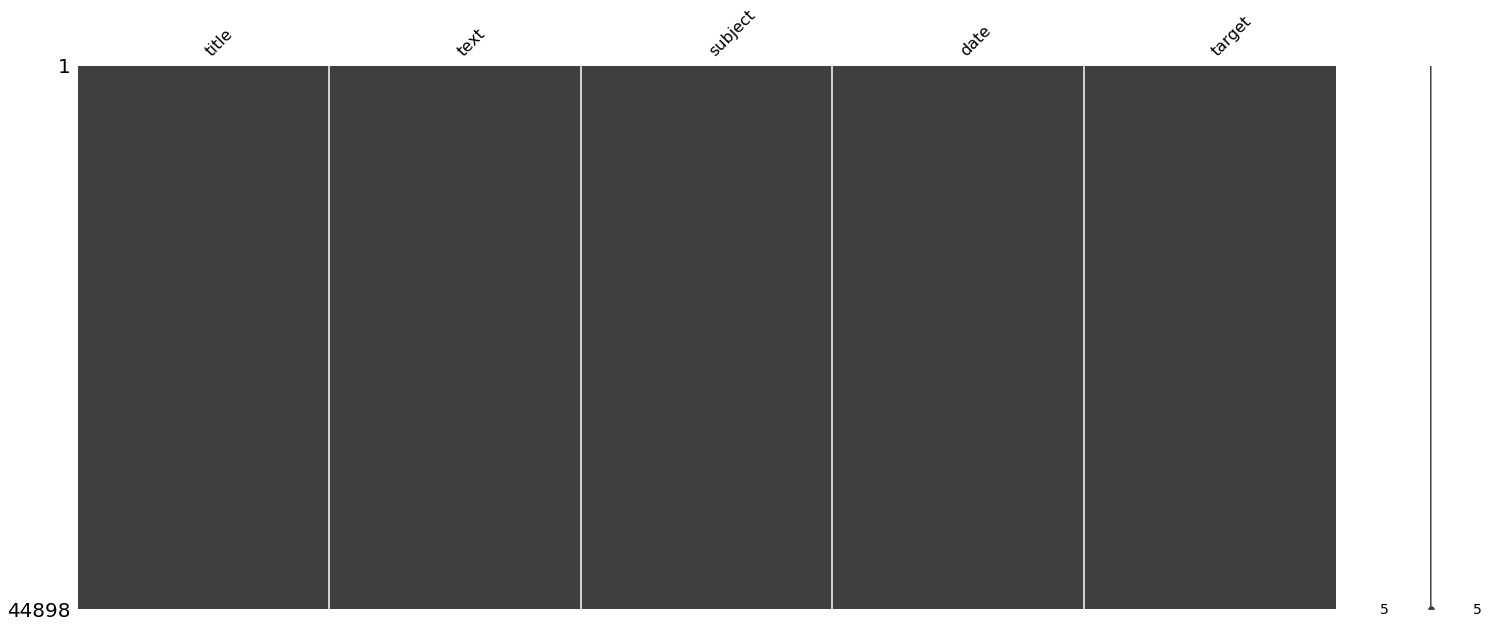

In [14]:
# Let's check if there is any missing value
%matplotlib inline
msno.matrix(df)

In [15]:
# As we see there is no missing value

In [16]:
# Classification with Bert

In [17]:
df.to_csv('data.csv', index=None)

# Starting Point

In [7]:
data = pd.read_csv("data.csv")

In [3]:
data.head()

,title,text,subject,date,target
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0


# Bert Model

## Bert Model Definition

In [4]:
from torch import nn
from transformers import BertModel

class BertClassifier(nn.Module):
    def __init__(self, bert_path, dropout, n_class):
        super(BertClassifier, self).__init__()
        self.bert_path = bert_path
        self.n_class = n_class
        self.dropout = nn.Dropout(dropout)
        self.bert = BertModel.from_pretrained(self.bert_path)
        self.fc = nn.Linear(self.bert.config.hidden_size, self.n_class)

    def forward(self, input_ids, attention_mask, token_type_ids):
        _, out = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids
        )
        out = self.dropout(out)
        out = self.fc(out)
        return out

## Dataset preparation

In [5]:
class TxtDataset:
    def __init__(self, text, target, tokenizer, max_len=512):
        self.text = text
        self.target = target
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, item):
        text = str(self.text[item])
        target = int(self.target[item])

        inputs = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True,
            return_attention_mask=True
        )

        input_ids = inputs["input_ids"]
        mask = inputs["attention_mask"]
        token_type_ids = inputs["token_type_ids"]

        out = {
            "input_ids": torch.tensor(input_ids, dtype=torch.long),
            "mask": torch.tensor(mask, dtype=torch.long),
            "token_type_ids": torch.tensor(token_type_ids, dtype=torch.long),
            "target": torch.tensor(target, dtype=torch.float)
        }
        return out

## Engine function definition (train, evaluation and predict)

In [6]:
def loss_fn(outputs, targets):
    """Loss function for binarie crossentropy"""
    criterion = torch.nn.BCEWithLogitsLoss().to(config.DEVICE)
    return criterion(outputs, targets)

In [7]:
def train(model, optimizer, data_loader):
    total_loss = 0
    y_pred = []
    y_true = []
    model.train()
    for idx, d in enumerate(tqdm(data_loader)):
        ids = d["input_ids"].to(config.DEVICE)
        mask = d["mask"].to(config.DEVICE)
        token_type_ids = d["token_type_ids"].to(config.DEVICE)
        target = d["target"].to(config.DEVICE)
        #print(outputs)
        #exit()

        optimizer.zero_grad()
        outputs = model(
            input_ids=ids,
            attention_mask=mask,
            token_type_ids=token_type_ids
        )
        probs = F.sigmoid(outputs)
        print(outputs[1])
        print(target.size())
        exit()
        
        loss = loss_fn(outputs[1], target)
        
        # Debugging
        #print(outputs)
        #print(f"loss {loss.item()}")
        #exit()
        
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        y_pred.append(torch.sigmoid(outputs).cpu().detach().numpy() > 0.5)
        y_true.append(target.cpu().detach().numpy())
    avg_loss = total_loss / len(data_loader)
    accuracy = accuracy_score(y_pred, y_true)
    return avg_loss, accuracy

In [8]:
def evaluate(model, optimizer, data_loader):
    total_loss = 0
    y_pred = []
    y_true = []
    model.eval()
    with torch.no_grad():
        for _, d in enumerate(tqdm(data_loader)):
            ids = d["input_ids"].to(config.DEVICE)
            mask = d["mask"].to(config.DEVICE)
            token_type_ids = d["token_type_ids"].to(config.DEVICE)
            target = d["target"].to(config.DEVICE)

            outputs = model(
                input_ids=ids,
                attention_mask=mask,
                token_type_ids=token_type_ids
            )
            loss = loss_fn(outputs,target)
            total_loss += loss.item()
            y_pred.append(torch.sigmoid(outputs).cpu().detach().numpy() > 0.5)
            y_true.append(target.cpu().detach().numpy())
        avg_loss = total_loss / len(data_loader)
        accuracy = accuracy_score(y_pred, y_true)
    return avg_loss, accuracy

## train steps wrapped

In [49]:
X = data.text.values
y = data.target.values

In [50]:
#train_df["label"] = train_df["label"].apply(lambda x: list(map(int, x)))

In [51]:
X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42
)

In [52]:
tokenizer = BertTokenizer.from_pretrained(config.BERT_TOKENIZER_PATH)

In [60]:
trainDataset = TxtDataset(
    text=X_train,
    target=y_train,
    tokenizer=tokenizer,
    max_len=config.MAX_LEN
)

trainDataLoader = DataLoader(
    dataset=trainDataset,
    sampler=RandomSampler(trainDataset),
    batch_size=config.TRAIN_BATCH_SIZE
)

In [61]:
testDataset = TxtDataset(
    text=X_test,
    target=y_test,
    tokenizer=tokenizer,
    max_len=config.MAX_LEN
)

testDataLoader = DataLoader(
    dataset=testDataset,
    sampler=SequentialSampler(testDataset),
    batch_size=config.VALID_BATCH_SIZE
)

In [62]:
model = BertClassifier(
    bert_path=config.BERT_MODEL_PATH,
    dropout=config.DROPOUT,
    n_class=2
)

In [63]:
best_test_acc = 0.0
best_epoch = 1
output_model_file = os.path.join(config.OUTPUT_DIR, WEIGHTS_NAME)
output_config_file = os.path.join(config.OUTPUT_DIR, CONFIG_NAME)

In [64]:
if os.path.exists(config.MODEL_CHECKPOINT):
    model = BertForSequenceClassification.from_pretrained(config.OUTPUT_DIR)
    model.to(config.DEVICE)
    optimizer = AdamW(model.parameters(), lr=config.LEARNING_RATE)
    # tokenizer = BertTokenizer.from_pretrained(config.OUTPUT_DIR)
    print("Loading model from last checkpoint...")
    state = torch.load(config.MODEL_CHECKPOINT)
    best_valid_acc = state['best_valid_acc']
    best_epoch = state['epoch']
    print(f"Best Validations Accuracy so far: {best_valid_acc:.3f} at Epoch {best_epoch}\n")
else:
    model = BertForSequenceClassification.from_pretrained("bert-base-uncased")
    model.to(config.DEVICE)
    optimizer = AdamW(model.parameters(), lr=config.LEARNING_RATE)

In [ ]:
for epoch in range(config.EPOCHS):
    real_epoch = best_epoch + epoch
    train_loss, train_acc = train(model, optimizer, trainDataLoader)
    test_loss, test_acc = evaluate(model, optimizer, testDataset)

    if test_acc > best_test_acc:
        best_test_acc = test_acc
        best_state_dict = copy.deepcopy(model.state_dict())
        print(
            f"Epoch {real_epoch: <{5}} | Train loss {train_loss:8.3f}| Train acc {train_acc:8.3f} | Valid loss {test_loss:8.3f} | Valid acc {test_acc:8.3f} | + "
        )

        # SAVING MODEL
        model_to_save = model.module if hasattr(model, 'module') else model
        torch.save(model_to_save.state_dict(), output_model_file)   # Saving the model
        model_to_save.config.to_json_file(output_config_file)   # Saving model configuration
        tokenizer.save_pretrained(config.OUTPUT_DIR)

        checkpoint = {
            'epoch': real_epoch,
            'best_valid_acc': best_test_acc,
            'best_state_dict': best_state_dict
        }
        model.config.to_json_file(config.OUTPUT_DIR)
        torch.save(checkpoint, config.MODEL_CHECKPOINT)
    else:
        print(
            f'Epoch {real_epoch: <{5}} | Train loss {train_loss:8.3f}| Train acc {train_acc:8.3f} | Valid loss {test_loss:8.3f} | Valid acc {test_acc:8.3f} |'
        )
print(f"The best Model Accuracy: {best_test_acc}")
print("The best Model has been saved")

# Inference for making prediction with new data

### Load the tokenizer from the pretrained vocabulary

In [23]:
tokenizer = BertTokenizer.from_pretrained(config.OUTPUT_DIR)

### Load the pretrained model

In [13]:
state_dict = torch.load(config.OUTPUT_MODEL_FILE)
model = BertClassifier(config.BERT_MODEL_PATH,config.DROPOUT,n_class=1)
model.load_state_dict(state_dict)

<All keys matched successfully>

## Let's make the prediction now

In [6]:
title = data.title[21591]
text = data.text[21591]

NameError: name 'data' is not defined

In [15]:
inputs = preprocess(title, text, tokenizer)
preds = predict(inputs=inputs, model=model)

In [16]:
preds

{'logits': 0.46889621019363403,
 'predictionValue': 1,
 'predictionText': 'True News',
 'predictionProbability': 0.6151224374771118}

# Convert the trained model to onnx runtime

In [9]:
import torch.onnx
from transformers import BertTokenizerFast
from fakenews.engine import preprocess, predict
from fakenews.model import BertClassifier
import pandas as pd

In [10]:
tokenizer = BertTokenizerFast.from_pretrained("./output/")
model = BertClassifier(bert_path="bert-base-uncased", dropout=0.3, n_class=1)

In [11]:
state = torch.load("model.bin")
model.load_state_dict(state)
model.eval()

BertClassifier(
  (dropout): Dropout(p=0.3, inplace=False)
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNor

In [12]:
dummy_title = data.title[24555]
dummy_text = data.text[24555]

In [13]:
dummy_input = preprocess(title=dummy_title, text=dummy_text, tokenizer=tokenizer)

In [108]:
dummy_input.keys()

dict_keys(['input_ids', 'attention_mask', 'token_type_ids'])

In [22]:
input_values = (dummy_input["input_ids"], dummy_input["attention_mask"], dummy_input["token_type_ids"])
input_name = ["input_ids", "attention_mask", "token_type_ids"]

In [23]:
# Now we compile to export the final onnx model
torch.onnx.export(model, input_values, "onnx_model.onnx", input_names=input_name)

# Reload the onnx model and test it

In [24]:
from onnxruntime import InferenceSession, ExecutionMode, SessionOptions

In [25]:
# Load the tokenizer
tokenizer = BertTokenizerFast.from_pretrained("./output/")

In [28]:
# Create the InferenceSession
options = SessionOptions()
options.intra_op_num_threads = 4
options.execution_mode = ExecutionMode.ORT_PARALLEL
session = InferenceSession("onnx_model.onnx", options)

In [29]:
logits = session.run(
    None, 
    {
        "input_ids":dummy_input["input_ids"].detach().cpu().numpy(),
        "attention_mask":dummy_input["attention_mask"].detach().cpu().numpy(),
        "token_type_ids":dummy_input["token_type_ids"].detach().cpu().numpy()
    }
)
logits

[array([[-0.16913885]], dtype=float32)]

In [30]:
logits_conv = torch.tensor(logits).flatten()
logits_conv

tensor([-0.1691])

In [31]:
logits_conv.item()

-0.1691388487815857

In [32]:
torch.sigmoid(logits_conv).item()

0.4578157663345337

In [203]:
def onnx_predict_f(inputs, model, session):
    """
    1: Means Real news
    0: Means Fake News
    """
    with torch.no_grad():
        logits = session.run(
            None, 
            {
                "input_ids":inputs["input_ids"].detach().cpu().numpy(),
                "attention_mask":inputs["attention_mask"].detach().cpu().numpy(),
                "token_type_ids":inputs["token_type_ids"].detach().cpu().numpy()
            }
        )
        logits = torch.tensor().flatten()
        
        prob = torch.sigmoid(logits).item()
        
        y_pred = int(prob> 0.5)
        logits = logits.item()
        
        y_pred_text = "Real News" if y_pred==0 else "True News"

        predictions = {
            "logits": logits,
            "predictionValue": y_pred,
            "predictionText": y_pred_text,
            "predictionProbability": prob
        }
        return predictions

# ONNX TEST

In [1]:
from onnxruntime import InferenceSession, ExecutionMode, SessionOptions
from fakenews.engine import onnx_predict, preprocess
from transformers import BertTokenizerFast
import torch
import pandas as pd

In [2]:
# Tokenizer
tokenizer = BertTokenizerFast.from_pretrained("./output/")

In [3]:
# Create the InferenceSession
options = SessionOptions()
options.intra_op_num_threads = 4
options.execution_mode = ExecutionMode.ORT_PARALLEL
session = InferenceSession("onnx_model.onnx")

In [4]:
data = pd.read_csv("data.csv")

In [5]:
input_title = data.title[33300]
input_text = data.text[33300]

In [6]:
input_title

'Hillary Clinton also wants Britain to stay in the EU'

In [7]:
input_text

'LONDON/WASHINGTON (Reuters) - U.S. Democratic presidential front-runner Hillary Clinton wants Britain to stay in the European Union, her campaign said on Saturday, following an intervention from U.S. President Barack Obama who urged Britons to vote to remain. “Hillary Clinton believes that transatlantic cooperation is essential, and that cooperation is strongest when Europe is united. She has always valued a strong United Kingdom in a strong EU. And she values a strong British voice in the EU,” Clinton senior policy adviser Jake Sullivan said in a statement provided to Reuters.  Clinton, who spent four years as U.S. secretary of state during Obama’s first term, has made her foreign policy credentials a central piece of her campaign for president in the November 2016 race for the White House.  Clinton’s position on the EU was first reported by Britain’s Observer newspaper.  Obama, who will leave Britain on Sunday, sparked a row during his three-day trip by bluntly telling Britain it sh

In [8]:
input_data = preprocess(title=input_title, text=input_text, tokenizer=tokenizer)

In [9]:
onnx_predict(inputs=input_data, session=session)

{'logits': 1.3884211778640747,
 'predictionValue': 1,
 'predictionText': 'Real News',
 'predictionProbability': 0.8003401160240173}

In [19]:
data["long"] = len(data.title + data.text)

In [20]:
max(data["long"])

44898

In [1]:
# Tika test

In [8]:
import tika
from tika import parser

In [3]:
tika.initVM()

In [7]:
doc = parser.from_file()

AttributeError: module 'tika' has no attribute 'parser'